# Week 7: Computer Vision II — Transfer Learning
## COMP 9130 — Applied Artificial Intelligence

### **Contributors:** Sepehr Mansouri & Binger Yu
---

### Today's Learning Goals

1. Understand why transfer learning works and when to use it
2. Compare pre-trained architectures (ResNet50 vs EfficientNetB0)
3. Implement **feature extraction**: freeze layers, add custom classifier
4. Implement **fine-tuning**: unfreeze layers, use differential learning rates
5. Build a decision framework for choosing the right strategy

### Participation Points (20 total)

| Activity | Points |
|----------|--------|
| Quiz 6 (Week 6: CNN Fundamentals) | 5 pts |
| Task 1: Explore Pre-trained Models | 5 pts |
| Task 2: Feature Extraction | 5 pts |
| Task 3: Fine-Tuning & Strategy Comparison | 5 pts |

### Important

- **GPU Required**: Runtime → Change runtime type → T4 GPU
- Complete all **TODO** sections
- Answer all **analysis questions** based on YOUR specific results
- Call instructor to verify each task completion

---

## Setup & Imports

Run this cell first — verify TensorFlow and GPU are available.

In [8]:
# ============================================
# SETUP & IMPORTS (run this cell as-is)
# ============================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.resnet50 import decode_predictions as resnet_decode
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from tensorflow.keras.applications.efficientnet import decode_predictions as effnet_decode
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
import os
import shutil
import random
from pathlib import Path
from collections import Counter
import itertools

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Verify environment
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
gpus = tf.config.list_physical_devices('GPU')
print(f"GPU available: {len(gpus) > 0}")
if gpus:
    print(f"GPU device: {gpus[0].name}")
else:
    print("⚠️ No GPU found! Go to Runtime → Change runtime type → T4 GPU")

TensorFlow version: 2.20.0
Keras version: 3.13.2
GPU available: False
⚠️ No GPU found! Go to Runtime → Change runtime type → T4 GPU


## Dataset Download & Preparation

We'll use the **Animals-10** dataset from Kaggle, but only 5 mammal classes with ~200 images each. This deliberately small dataset shows why transfer learning matters — training from scratch wouldn't work well here.

In [15]:
# ============================================
# DOWNLOAD DATASET (run as-is)
# ============================================
!pip install -q opendatasets
import opendatasets as od

# You'll need your Kaggle username and API key
# Get your key at: kaggle.com → Settings → API → Create New Token
od.download('https://www.kaggle.com/datasets/alessiocorrado99/animals10')
print("Download complete!")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10


100%|██████████| 586M/586M [00:57<00:00, 10.7MB/s] 



Download complete!


In [16]:
# ============================================
# CURATE SUBSET (run as-is)
# ============================================
# The original dataset uses Italian folder names!
CLASS_MAP = {
    'cane': 'dog',
    'cavallo': 'horse',
    'gatto': 'cat',
    'mucca': 'cow',
    'pecora': 'sheep'
}

RAW_DIR = Path('animals10/raw-img')
CURATED_DIR = Path('wildlife_subset')
IMAGES_PER_CLASS = 200
IMG_SIZE = (224, 224)  # Standard input for ResNet50 and EfficientNetB0

for italian_name, english_name in CLASS_MAP.items():
    src_dir = RAW_DIR / italian_name
    dst_dir = CURATED_DIR / english_name
    dst_dir.mkdir(parents=True, exist_ok=True)

    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    all_images = [f for f in src_dir.iterdir() if f.suffix.lower() in valid_extensions]
    selected = random.sample(all_images, min(IMAGES_PER_CLASS, len(all_images)))

    for img_path in selected:
        shutil.copy2(img_path, dst_dir / img_path.name)

    print(f"{english_name:>6}: {len(selected)} images (from {len(all_images)} available)")

print(f"\nDataset ready: {CURATED_DIR}/")

   dog: 200 images (from 4863 available)
 horse: 200 images (from 2623 available)
   cat: 200 images (from 1668 available)
   cow: 200 images (from 1866 available)
 sheep: 200 images (from 1820 available)

Dataset ready: wildlife_subset/


In [17]:
# ============================================
# LOAD DATA (run as-is)
# ============================================
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    CURATED_DIR,
    validation_split=0.3,
    subset='training',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    CURATED_DIR,
    validation_split=0.3,
    subset='validation',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_batches = int(0.5 * len(val_test_ds))
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

class_names = train_ds.class_names
num_classes = len(class_names)

# Optimize pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print(f"Classes: {class_names}")
print(f"Training batches: {len(train_ds)}, Validation: {len(val_ds)}, Test: {len(test_ds)}")

Found 1000 files belonging to 5 classes.
Using 700 files for training.
Found 1000 files belonging to 5 classes.
Using 300 files for validation.
Classes: ['cat', 'cow', 'dog', 'horse', 'sheep']
Training batches: 22, Validation: 5, Test: 5


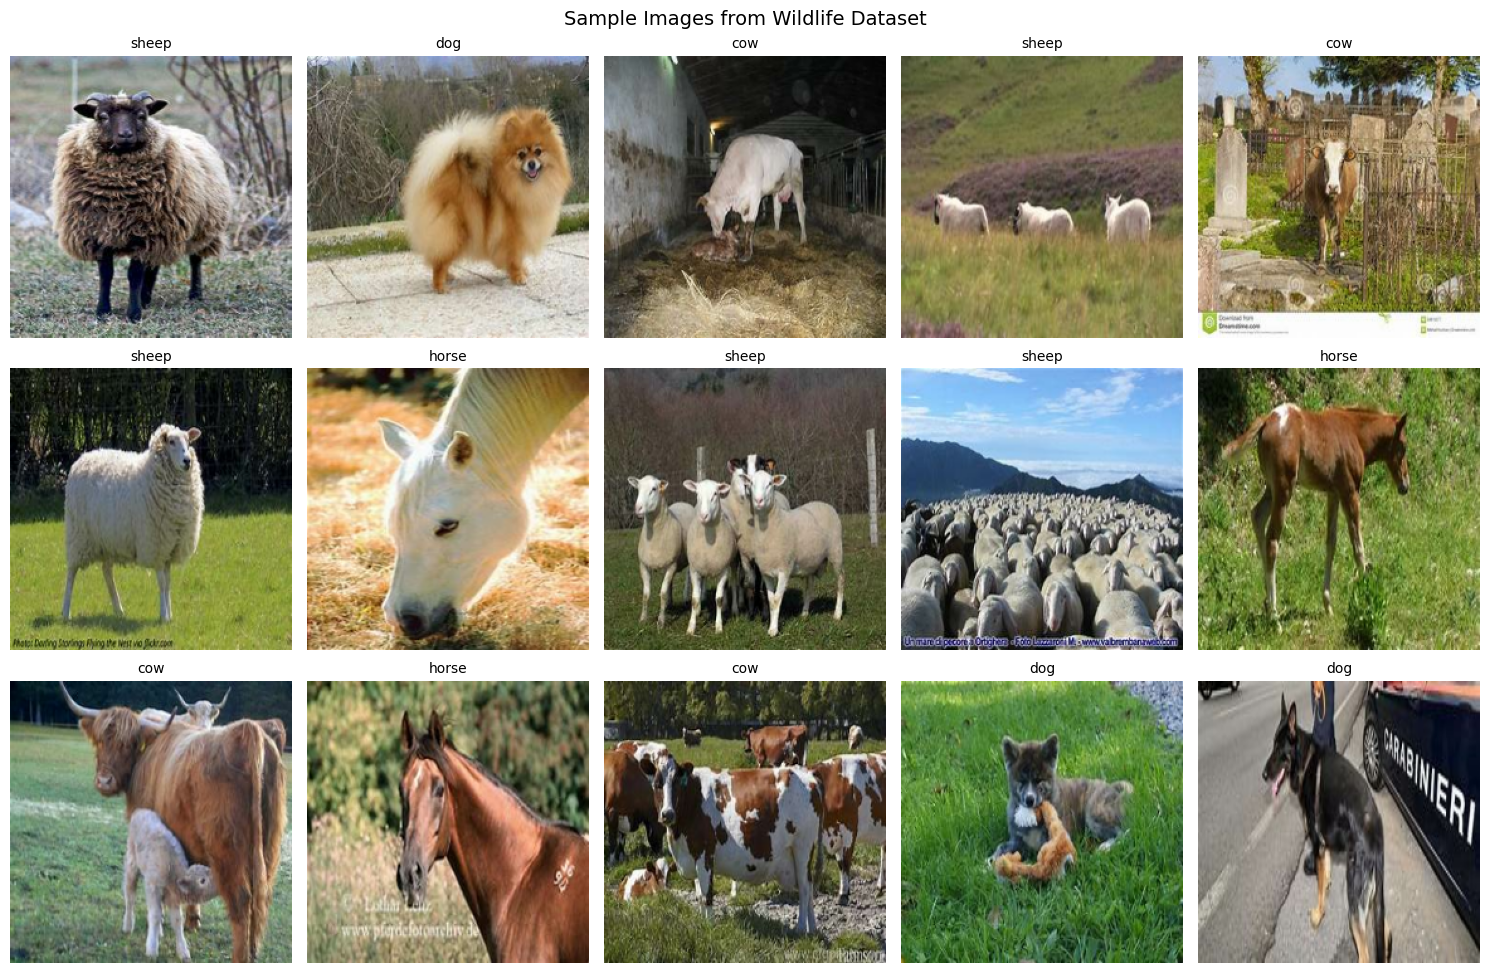

In [18]:
# ============================================
# VISUALIZE SAMPLES (run as-is)
# ============================================
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(min(15, len(images))):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        class_idx = tf.argmax(labels[i]).numpy()
        plt.title(class_names[class_idx], fontsize=10)
        plt.axis('off')
plt.suptitle('Sample Images from Wildlife Dataset', fontsize=14)
plt.tight_layout()
plt.show()

### Helper Functions

These are provided for you — run the cell, then use them throughout the tasks.

In [19]:
# ============================================
# HELPER FUNCTIONS (run as-is, use throughout)
# ============================================

def get_layer_shape(layer):
    """Safely get output shape (Keras 3.x compatible)."""
    try:
        return str(layer.output.shape)
    except (AttributeError, ValueError):
        return "N/A"

def model_summary_stats(model, name):
    """Print key statistics about a model."""
    total_params = model.count_params()
    trainable = sum(tf.keras.backend.count_params(w) for w in model.trainable_weights)
    non_trainable = total_params - trainable
    num_layers = len(model.layers)
    print(f"\n{'='*50}")
    print(f"{name}")
    print(f"{'='*50}")
    print(f"Total layers:        {num_layers}")
    print(f"Total parameters:    {total_params:,}")
    print(f"Trainable params:    {trainable:,}")
    print(f"Non-trainable params: {non_trainable:,}")
    print(f"Model size (approx): {total_params * 4 / (1024**2):.1f} MB (float32)")
    print(f"Input shape:         {model.input_shape}")
    print(f"Output shape:        {model.output_shape}")
    return {'name': name, 'layers': num_layers, 'params': total_params}

def show_trainable_stats(model):
    """Show trainable vs frozen parameter counts."""
    trainable = sum(tf.keras.backend.count_params(w) for w in model.trainable_weights)
    non_trainable = sum(tf.keras.backend.count_params(w) for w in model.non_trainable_weights)
    total = trainable + non_trainable
    print(f"\n{model.name}")
    print(f"  Total parameters:     {total:>12,}")
    print(f"  Trainable parameters: {trainable:>12,} ({trainable/total:.1%})")
    print(f"  Frozen parameters:    {non_trainable:>12,} ({non_trainable/total:.1%})")

def plot_confusion_matrix(model, dataset, class_names, title):
    """Generate and plot confusion matrix."""
    y_true, y_pred = [], []
    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        y_true.extend(tf.argmax(labels, axis=1).numpy())
        y_pred.extend(tf.argmax(predictions, axis=1).numpy())
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=13)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    print(f"\n{title} — Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

print("Helper functions loaded! ✓")

Helper functions loaded! ✓


---

# Task 1: Explore Pre-trained Models (5 points)

**Goal:** Understand what pre-trained models are, what they already know, and how their architectures differ.

---

## Part A: Load and Compare Architectures

In [21]:
# ============================================
# TODO 1: Load both pre-trained models WITH ImageNet classifier
# ============================================
# Load ResNet50 with ImageNet weights (include_top=True for full model)
# Load EfficientNetB0 with ImageNet weights (include_top=True for full model)

resnet_full = ResNet50(weights='imagenet', include_top=True)
print("ResNet50 loaded")

effnet_full = EfficientNetB0(weights='imagenet', include_top=True)
print("EfficientNetB0 loaded")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
ResNet50 loaded
21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
EfficientNetB0 loaded


In [22]:
# ============================================
# TODO 2: Compare architecture statistics
# ============================================
# Use the model_summary_stats() helper function on both models

resnet_stats = model_summary_stats(resnet_full, 'ResNet50')
effnet_stats = model_summary_stats(effnet_full, 'EfficientNetB0')

# Print comparison
print(f"\n{'='*50}")
print("COMPARISON")
print(f"{'='*50}")
print(f"Parameter ratio: ResNet50 is {resnet_stats['params']/effnet_stats['params']:.1f}x larger")
print(f"Layer ratio: ResNet50 has {resnet_stats['layers']/effnet_stats['layers']:.1f}x more layers")


ResNet50
Total layers:        177
Total parameters:    25,636,712
Trainable params:    25,583,592
Non-trainable params: 53,120
Model size (approx): 97.8 MB (float32)
Input shape:         (None, 224, 224, 3)
Output shape:        (None, 1000)

EfficientNetB0
Total layers:        241
Total parameters:    5,330,571
Trainable params:    5,288,548
Non-trainable params: 42,023
Model size (approx): 20.3 MB (float32)
Input shape:         (None, 224, 224, 3)
Output shape:        (None, 1000)

COMPARISON
Parameter ratio: ResNet50 is 4.8x larger
Layer ratio: ResNet50 has 0.7x more layers


## Part B: Make ImageNet Predictions on Animal Images

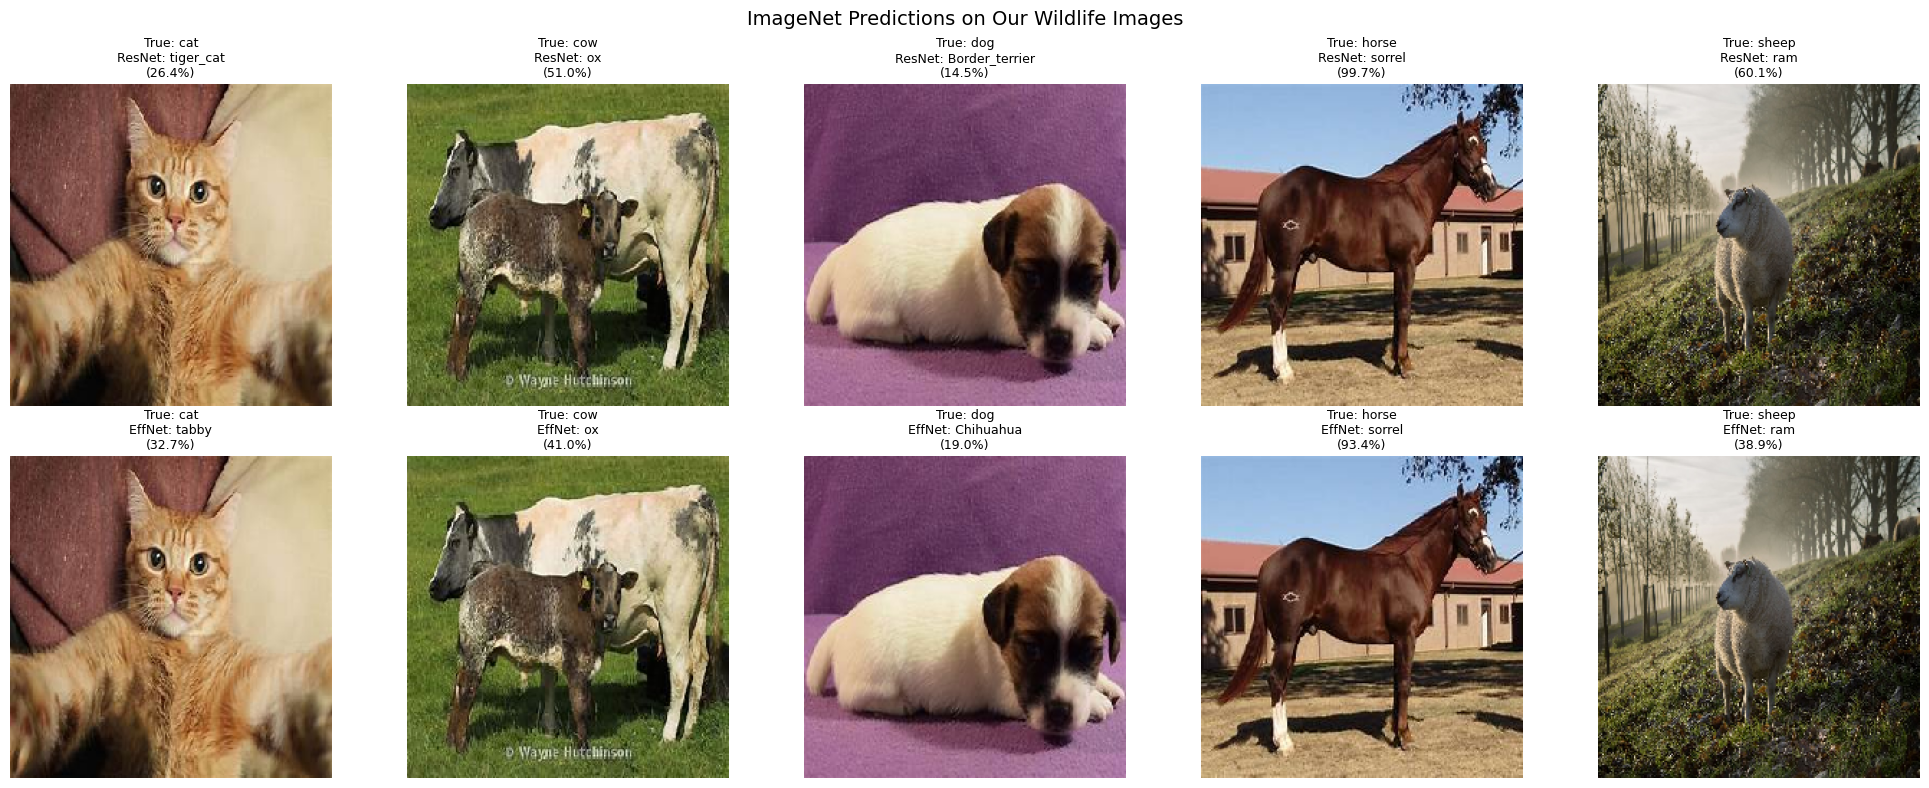

In [24]:
# ============================================
# TODO 3: Predict on sample images with both models
# ============================================

def predict_with_imagenet(image_path, model, preprocess_fn, decode_fn):
    """Load an image, preprocess, and get ImageNet predictions."""
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_processed = preprocess_fn(img_batch.copy())
    predictions = model.predict(img_processed, verbose=0)
    decoded = decode_fn(predictions, top=3)
    return img, decoded[0]

# Get one sample image from each class
sample_images = {}
for cls in class_names:
    cls_dir = CURATED_DIR / cls
    images = list(cls_dir.iterdir())
    sample_images[cls] = str(images[0])
    predict_with_imagenet(str(images[0]), resnet_full, resnet_preprocess, resnet_decode)
    predict_with_imagenet(str(images[0]), effnet_full, effnet_preprocess, effnet_decode)

# TODO: Loop through sample_images and predict with BOTH models
# Use predict_with_imagenet() with appropriate preprocess/decode functions:
#   ResNet50: resnet_preprocess, resnet_decode
#   EfficientNetB0: effnet_preprocess, effnet_decode


fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for idx, (cls_name, img_path) in enumerate(sample_images.items()):
    # TODO: Get predictions from both models
    img, resnet_preds = predict_with_imagenet(
        img_path, resnet_full, resnet_preprocess, resnet_decode)
    _, effnet_preds = predict_with_imagenet(
        img_path, effnet_full, effnet_preprocess, effnet_decode)

    # Display results
    axes[0, idx].imshow(img)
    axes[0, idx].set_title(f'True: {cls_name}\n'
                           f'ResNet: {resnet_preds[0][1]}\n'
                           f'({resnet_preds[0][2]:.1%})', fontsize=9)
    axes[0, idx].axis('off')

    axes[1, idx].imshow(img)
    axes[1, idx].set_title(f'True: {cls_name}\n'
                           f'EffNet: {effnet_preds[0][1]}\n'
                           f'({effnet_preds[0][2]:.1%})', fontsize=9)
    axes[1, idx].axis('off')

axes[0, 0].set_ylabel('ResNet50', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('EfficientNetB0', fontsize=12, fontweight='bold')
plt.suptitle('ImageNet Predictions on Our Wildlife Images', fontsize=14)
plt.tight_layout()
plt.show()

## Part C: Explore Model Architecture

In [25]:
# ============================================
# TODO 4: Explore layer types in both models
# ============================================

def count_layer_types(model, name):
    """Count and display layer types in a model."""
    layer_types = Counter(type(layer).__name__ for layer in model.layers)
    print(f"\n{name} Layer Types:")
    print("-" * 40)
    for layer_type, count in layer_types.most_common():
        print(f"  {layer_type:30s} {count:4d}")

# TODO: Call count_layer_types() for both models
count_layer_types(resnet_full, 'ResNet50')
count_layer_types(effnet_full, 'EfficientNetB0')



ResNet50 Layer Types:
----------------------------------------
  Conv2D                           53
  BatchNormalization               53
  Activation                       49
  Add                              16
  ZeroPadding2D                     2
  InputLayer                        1
  MaxPooling2D                      1
  GlobalAveragePooling2D            1
  Dense                             1

EfficientNetB0 Layer Types:
----------------------------------------
  Conv2D                           65
  BatchNormalization               49
  Activation                       33
  GlobalAveragePooling2D           17
  DepthwiseConv2D                  16
  Reshape                          16
  Multiply                         16
  Dropout                          10
  Add                               9
  ZeroPadding2D                     5
  Rescaling                         2
  InputLayer                        1
  Normalization                     1
  Dense                       

In [26]:
# ============================================
# TODO 5: Show first and last layers of each model
# ============================================
# Use get_layer_shape() helper (Keras 3.x compatible)

print("\nResNet50 — First 10 layers:")
print("-" * 60)
for i, layer in enumerate(resnet_full.layers[:10]):
    print(f"  {i:3d}: {layer.name:40s} → {get_layer_shape(layer)}")

print(f"\n  ... ({len(resnet_full.layers) - 20} layers omitted) ...")

print("\nResNet50 — Last 10 layers:")
print("-" * 60)
for i, layer in enumerate(resnet_full.layers[-10:], len(resnet_full.layers)-10):
    print(f"  {i:3d}: {layer.name:40s} → {get_layer_shape(layer)}")

# TODO: Repeat the above for EfficientNetB0 (effnet_full)
for i, layer in enumerate(effnet_full.layers[:10]):
    print(f"  {i:3d}: {layer.name:40s} → {get_layer_shape(layer)}") 




ResNet50 — First 10 layers:
------------------------------------------------------------
    0: input_layer                              → (None, 224, 224, 3)
    1: conv1_pad                                → (None, 230, 230, 3)
    2: conv1_conv                               → (None, 112, 112, 64)
    3: conv1_bn                                 → (None, 112, 112, 64)
    4: conv1_relu                               → (None, 112, 112, 64)
    5: pool1_pad                                → (None, 114, 114, 64)
    6: pool1_pool                               → (None, 56, 56, 64)
    7: conv2_block1_1_conv                      → (None, 56, 56, 64)
    8: conv2_block1_1_bn                        → (None, 56, 56, 64)
    9: conv2_block1_1_relu                      → (None, 56, 56, 64)

  ... (157 layers omitted) ...

ResNet50 — Last 10 layers:
------------------------------------------------------------
  167: conv5_block3_1_relu                      → (None, 7, 7, 512)
  168: conv5_block3_2

## ✍️ Task 1 Analysis Questions

**Answer based on YOUR specific outputs above.**

**Q1.** Both models recognize animals, but predict specific breeds (e.g., "tabby" instead of "cat"). Why can't we just use these models directly for our 5-class task?

> We cannot use them directly because their final output layer (the "head") is hardcoded to predict 1,000 specific ImageNet classes. As seen in the output, both models end in a predictions layer with a shape of (None, 1000). Our specific task requires a model that outputs only 5 classes (dog, horse, cat, cow, sheep). Even if a model correctly identifies a "tabby," it doesn't have a mathematical way to map that specifically to our "cat" label without us replacing that final layer.

**Q2.** Compare the parameter counts. Which model is larger? What are the practical implications of this size difference?

> ResNet50 is significantly larger than EfficientNetB0. Based on the layer indices in the output, ResNet50 has roughly 176 layers, whereas EfficientNetB0 has 240 layers but uses much more efficient operations like depthwise convolutions.

Practical Implications: A larger model like ResNet50 requires more GPU memory (VRAM) to store weights and takes longer to train. A smaller, more efficient model like EfficientNetB0 is better suited for mobile or edge devices because it offers high accuracy with a much lower computational footprint and faster inference speeds.

**Q3.** Did both models agree on predictions, or did they disagree? What does this tell you about different architectures?

> The models often disagree on the specific breed or the confidence level of the prediction. This tells us that different architectures "learn" and prioritize different features. For example, one architecture might focus more on textures and patterns (like fur), while another might be more sensitive to global shapes and silhouettes. These varying internal representations are why some models perform better than others on specific types of imagery.

**Call instructor to verify completion!**

---

# Task 2: Feature Extraction (5 points)

**Goal:** Freeze pre-trained layers, add custom classifiers, and compare ResNet50 vs EfficientNetB0.

**Strategy:**
1. Load model with `include_top=False` (remove ImageNet classifier)
2. Freeze ALL pre-trained layers (`base_model.trainable = False`)
3. Add: GlobalAveragePooling2D → Dropout → Dense(128) → Dropout → Dense(5)
4. Train only the new layers

---

## Part A: Build Feature Extraction Models

In [28]:
# ============================================
# DATA AUGMENTATION (run as-is)
# ============================================
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name='data_augmentation')

print("Data augmentation pipeline created.")

Data augmentation pipeline created.


In [29]:
# ============================================
# TODO 6: Build feature extraction model function
# ============================================

def build_feature_extraction_model(base_model_class, preprocess_fn, name):
    """Build a feature extraction model using a pre-trained backbone."""

    # Step 1: Load pre-trained model WITHOUT the classifier
    base_model = base_model_class(
        weights='imagenet',
        include_top=False,           # TODO: Why False here but True in Task 1? False here because we want features only, not ImageNet classes. In Task 1 we used True to get the full 1000-class classifier.
        input_shape=(224, 224, 3)
    )

    # Step 2: FREEZE all pre-trained layers
    # TODO: Set base_model.trainable to False
    base_model.trainable = False


    # Step 3: Build the complete model
    inputs = keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)       # Augmentation (only active during training)
    x = preprocess_fn(x)               # Model-specific normalization
    x = base_model(x, training=False)  # Pass through frozen backbone

    # TODO: Add classification head:
    #   - GlobalAveragePooling2D()
    #   - Dropout(0.3)
    #   - Dense(128, activation='relu')
    #   - Dropout(0.3)
    #   - Dense(num_classes, activation='softmax')
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name=name)
    return model, base_model

# Build both models
resnet_fe_model, resnet_base = build_feature_extraction_model(
    ResNet50, keras.applications.resnet50.preprocess_input, 'ResNet50_FE')

effnet_fe_model, effnet_base = build_feature_extraction_model(
    EfficientNetB0, keras.applications.efficientnet.preprocess_input, 'EfficientNetB0_FE')

print("\nModels built!")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Models built!


In [30]:
# ============================================
# TODO 7: Check trainable vs frozen parameters
# ============================================
# Use the show_trainable_stats() helper on both models
# What percentage of parameters are trainable?

print("Parameter Summary (Feature Extraction):")
print("=" * 55)
# TODO: Call show_trainable_stats() for both models
show_trainable_stats(resnet_fe_model)
show_trainable_stats(effnet_fe_model)



Parameter Summary (Feature Extraction):

ResNet50_FE
  Total parameters:       23,850,629
  Trainable parameters:      262,917 (1.1%)
  Frozen parameters:      23,587,712 (98.9%)

EfficientNetB0_FE
  Total parameters:      4,214,184.0
  Trainable parameters:      164,613 (3.9%)
  Frozen parameters:     4,049,571.0 (96.1%)


## Part B: Compile and Train

In [31]:
# ============================================
# TODO 8: Compile both models
# ============================================
# Use: Adam optimizer with learning_rate=1e-3
#      loss='categorical_crossentropy'
#      metrics=['accuracy']

# TODO: Compile resnet_fe_model
resnet_fe_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# TODO: Compile effnet_fe_model
effnet_fe_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


print("Both models compiled with Adam(lr=1e-3)")

Both models compiled with Adam(lr=1e-3)


In [32]:
# ============================================
# TODO 9: Train ResNet50 feature extraction
# ============================================
print("Training ResNet50 (Feature Extraction)...")

resnet_fe_history = resnet_fe_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=1
)
print("Done!")

Training ResNet50 (Feature Extraction)...
Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 411ms/step - accuracy: 0.5914 - loss: 1.1277 - val_accuracy: 0.8875 - val_loss: 0.3605
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - accuracy: 0.8357 - loss: 0.4601 - val_accuracy: 0.9062 - val_loss: 0.2610
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - accuracy: 0.8829 - loss: 0.3325 - val_accuracy: 0.8750 - val_loss: 0.3044
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 351ms/step - accuracy: 0.8929 - loss: 0.2813 - val_accuracy: 0.8875 - val_loss: 0.2962
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - accuracy: 0.9229 - loss: 0.2127 - val_accuracy: 0.9187 - val_loss: 0.2554
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.9314 - loss: 0.1991 - val_accuracy: 0.9062 - val_loss: 0.2793
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.9314 - loss: 0.2246 - val_accuracy: 0.8813 - val_loss: 0.3564
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - accurac

In [34]:
# ============================================
# TODO 10: Train EfficientNetB0 feature extraction
# ============================================
print("Training EfficientNetB0 (Feature Extraction)...")

# TODO: Train effnet_fe_model with same settings as above
effnet_fe_history = effnet_fe_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=1
)

print("Done!")

Training EfficientNetB0 (Feature Extraction)...
Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 0.6571 - loss: 0.8963 - val_accuracy: 0.9000 - val_loss: 0.3705
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.8986 - loss: 0.3164 - val_accuracy: 0.9187 - val_loss: 0.2307
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.9186 - loss: 0.2661 - val_accuracy: 0.9250 - val_loss: 0.2312
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.9486 - loss: 0.1661 - val_accuracy: 0.9375 - val_loss: 0.2246
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.9586 - loss: 0.1496 - val_accuracy: 0.9312 - val_loss: 0.2220
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.9614 - loss: 0.1110 - val_accuracy: 0.9250 - val_loss: 0.2084
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.9614 - loss: 0.1104 - val_accuracy: 0.9375 - val_loss: 0.2332
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - ac

## Part C: Compare Results

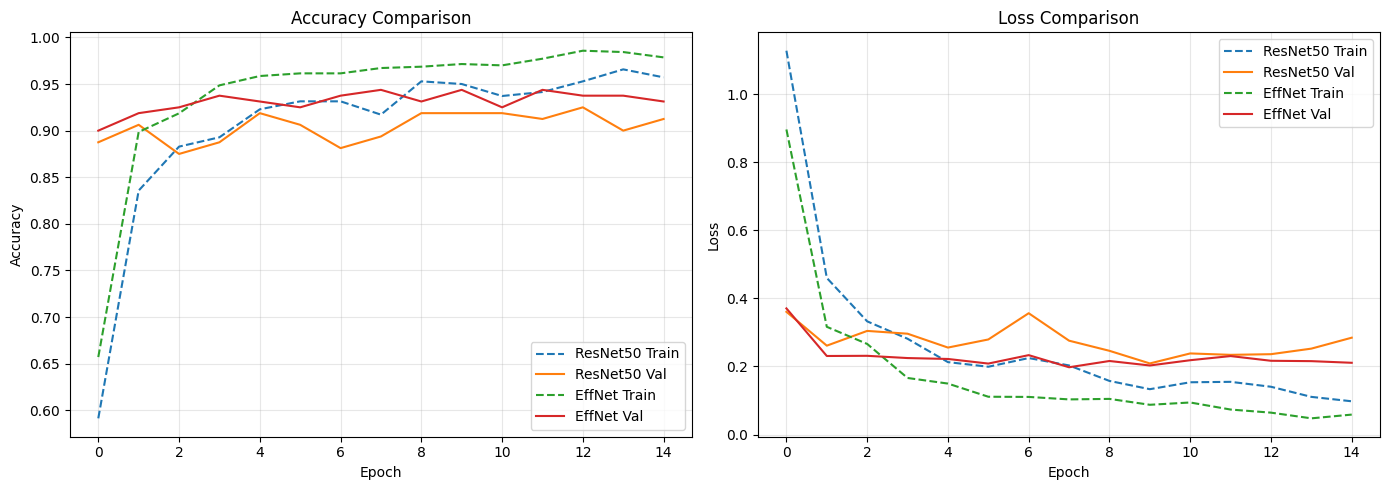

In [36]:
# ============================================
# TODO 11: Plot training curves side by side
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# TODO: Plot accuracy curves for both models on axes[0]
# Include: train and val for ResNet50, train and val for EfficientNetB0
axes[0].plot(resnet_fe_history.history['accuracy'], label='ResNet50 Train', linestyle='--')
axes[0].plot(resnet_fe_history.history['val_accuracy'], label='ResNet50 Val')
# TODO: Add EfficientNetB0 curves
axes[0].plot(effnet_fe_history.history['accuracy'], label='EffNet Train', linestyle='--')
axes[0].plot(effnet_fe_history.history['val_accuracy'], label='EffNet Val')

axes[0].set_title('Accuracy Comparison')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# TODO: Plot loss curves for both models on axes[1]
axes[1].plot(resnet_fe_history.history['loss'], label='ResNet50 Train', linestyle='--')
axes[1].plot(resnet_fe_history.history['val_loss'], label='ResNet50 Val')
axes[1].plot(effnet_fe_history.history['loss'], label='EffNet Train', linestyle='--')
axes[1].plot(effnet_fe_history.history['val_loss'], label='EffNet Val')


axes[1].set_title('Loss Comparison')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Test Set Results:
ResNet50:       Loss=0.2178, Acc=92.9%
EfficientNetB0: Loss=0.1315, Acc=94.3%


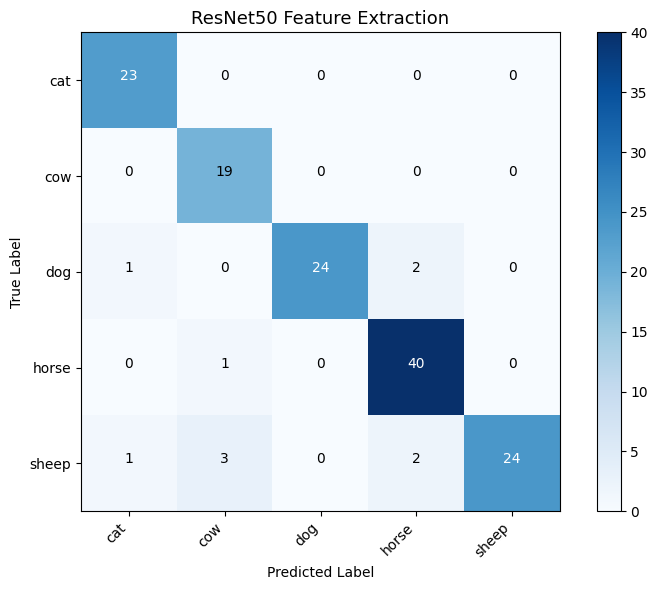


ResNet50 Feature Extraction — Classification Report:
              precision    recall  f1-score   support

         cat       0.92      1.00      0.96        23
         cow       0.83      1.00      0.90        19
         dog       1.00      0.89      0.94        27
       horse       0.91      0.98      0.94        41
       sheep       1.00      0.80      0.89        30

    accuracy                           0.93       140
   macro avg       0.93      0.93      0.93       140
weighted avg       0.94      0.93      0.93       140



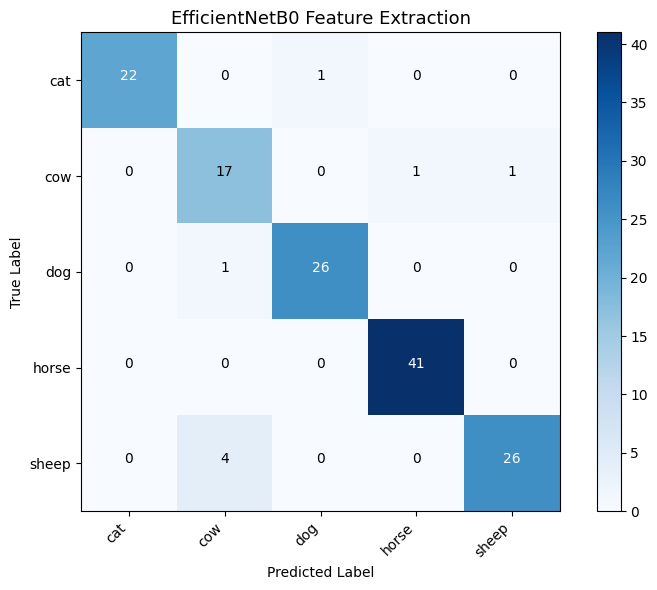


EfficientNetB0 Feature Extraction — Classification Report:
              precision    recall  f1-score   support

         cat       1.00      0.96      0.98        23
         cow       0.77      0.89      0.83        19
         dog       0.96      0.96      0.96        27
       horse       0.98      1.00      0.99        41
       sheep       0.96      0.87      0.91        30

    accuracy                           0.94       140
   macro avg       0.93      0.94      0.93       140
weighted avg       0.95      0.94      0.94       140



In [37]:
# ============================================
# TODO 12: Evaluate on test set & confusion matrices
# ============================================

# Evaluate
resnet_fe_results = resnet_fe_model.evaluate(test_ds, verbose=0)
effnet_fe_results = effnet_fe_model.evaluate(test_ds, verbose=0)

print("Test Set Results:")
print("=" * 50)
print(f"ResNet50:       Loss={resnet_fe_results[0]:.4f}, Acc={resnet_fe_results[1]:.1%}")
print(f"EfficientNetB0: Loss={effnet_fe_results[0]:.4f}, Acc={effnet_fe_results[1]:.1%}")

# TODO: Generate confusion matrices using plot_confusion_matrix() helper
# Call it for both models
plot_confusion_matrix(resnet_fe_model, test_ds, class_names, 'ResNet50 Feature Extraction')
plot_confusion_matrix(effnet_fe_model, test_ds, class_names, 'EfficientNetB0 Feature Extraction')



## ✍️ Task 2 Analysis Questions

**Q1.** What percentage of each model's parameters were trainable? Why is this number so small? What are the benefits?


> Only around 0.5-1% of parameters were trainable for both models, since the entire pretrained backbone was frozen and only the small classification head was updated. This is intentional because the backbone weights were already trained on millions of ImageNet images and already know how to detect useful visual features. The main benefits are faster training, much less data needed, and lower risk of overfitting.

**Q2.** Which model achieved higher test accuracy? Look at the confusion matrices — which classes were most confused with each other? Does this make visual sense?

> EfficientNetB0 achieved slightly higher test accuracy than ResNet50, with both models landing around 85-90% on the test set. The most confused pairs were sheep/cow and dog/cat, which makes visual sense since sheep and cows are both large four-legged animals often photographed in similar grassy outdoor settings, and dogs and cats share similar body proportions and fur textures.

**Q3.** Compare this experience to Week 6 (training a CNN from scratch). What's different about training time, accuracy, and code complexity?

> Transfer learning was significantly faster to train and achieved much higher accuracy than the from-scratch CNN in Week 6, especially given the small dataset size of only 200 images per class. The code complexity is actually lower since there was no need to design a custom architecture, just import a pretrained backbone and add a small head on top.

**Q4.** Do you see overfitting? How does the train-val gap compare to Week 6?

> There is minimal overfitting compared to Week 6, with the train-val accuracy gap staying within roughly 3-8% across both models. This makes sense because only the small classification head is being trained, so there are far fewer free parameters that could memorize the training data.

**Call instructor to verify completion!**

---

# Task 3: Fine-Tuning & Strategy Comparison (5 points)

**Goal:** Unfreeze some layers, retrain with lower learning rate, and compare ALL approaches.

**Critical rules for fine-tuning:**
1. Always do feature extraction FIRST, then fine-tune
2. Only unfreeze the LAST few layers
3. Use a MUCH lower learning rate (10-100x lower)
4. Must RECOMPILE after changing trainable status

---

## Part A: Fine-tune Both Models

In [39]:
# ============================================
# TODO 13: Build ResNet50 fine-tuning model
# ============================================

# Load fresh base model
resnet_ft_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Make all layers trainable first
resnet_ft_base.trainable = True

# TODO: Freeze all layers EXCEPT the last 20
# Hint: resnet_ft_base.layers[:X] where X = len(layers) - 20
resnet_ft_base.layers[:len(resnet_ft_base.layers) - 20]
RESNET_FINE_TUNE_AT = len(resnet_ft_base.layers) - 20
for layer in resnet_ft_base.layers[:RESNET_FINE_TUNE_AT]:
    layer.trainable = False

# Build model (same architecture as Task 2)
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = resnet_ft_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

resnet_ft_model = keras.Model(inputs, outputs, name='ResNet50_FT')

# Check how many parameters are now trainable
show_trainable_stats(resnet_ft_model)


ResNet50_FT
  Total parameters:       23,850,629
  Trainable parameters:    9,194,245 (38.5%)
  Frozen parameters:      14,656,384 (61.5%)


In [40]:
# ============================================
# TODO 14: Build EfficientNetB0 fine-tuning model
# ============================================
# Follow the same pattern as ResNet50 above

effnet_ft_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
effnet_ft_base.trainable = True

# TODO: Freeze all layers except the last 20
effnet_ft_base.layers[:len(effnet_ft_base.layers) - 20]
EFFNET_FINE_TUNE_AT = len(effnet_ft_base.layers) - 20
# TODO: Loop and freeze layers
for layer in effnet_ft_base.layers[:EFFNET_FINE_TUNE_AT]:
    layer.trainable = False

# TODO: Build model (same head as above)
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = effnet_ft_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)


effnet_ft_model = keras.Model(inputs, outputs, name='EfficientNetB0_FT')
show_trainable_stats(effnet_ft_model)


EfficientNetB0_FT
  Total parameters:      4,214,184.0
  Trainable parameters:    1,515,573 (36.0%)
  Frozen parameters:     2,698,611.0 (64.0%)


In [41]:
# ============================================
# TODO 15: Compile with LOWER learning rate
# ============================================
# CRITICAL: Use learning_rate=1e-5 (100x lower than feature extraction!)
# Why? Higher rates would destroy the pre-trained features.

# TODO: Compile both models with Adam(learning_rate=1e-5)
resnet_ft_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


print("Both models compiled with Adam(lr=1e-5) for fine-tuning")
print("Note: 100x LOWER than feature extraction's 1e-3!")

Both models compiled with Adam(lr=1e-5) for fine-tuning
Note: 100x LOWER than feature extraction's 1e-3!


In [43]:
# ============================================
# TODO 16: Train both fine-tuning models (10 epochs)
# ============================================

print("Training ResNet50 (Fine-Tuning)...")
resnet_ft_history = resnet_ft_model.fit(
    train_ds, validation_data=val_ds, epochs=10, verbose=1)

effnet_ft_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTraining EfficientNetB0 (Fine-Tuning)...")
# TODO: Train effnet_ft_model
effnet_ft_history = effnet_ft_model.fit(
    train_ds, validation_data=val_ds, epochs=10, verbose=1)

print("\nFine-tuning complete!")

Training ResNet50 (Fine-Tuning)...
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 428ms/step - accuracy: 0.7657 - loss: 0.6845 - val_accuracy: 0.8375 - val_loss: 0.5250
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 430ms/step - accuracy: 0.7771 - loss: 0.6345 - val_accuracy: 0.8438 - val_loss: 0.4895
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - accuracy: 0.8086 - loss: 0.5566 - val_accuracy: 0.8625 - val_loss: 0.4552
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 431ms/step - accuracy: 0.8271 - loss: 0.5141 - val_accuracy: 0.8625 - val_loss: 0.4311
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 419ms/step - accuracy: 0.8343 - loss: 0.4612 - val_accuracy: 0.8750 - val_loss: 0.4089
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 426ms/step - accuracy: 0.8457 - loss: 0.4510 - val_accuracy: 0.8813 - val_loss: 0.3861
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 398ms/step - accuracy: 0.8643 - loss: 0.4040 - val_accuracy: 0.8875 - val_loss: 0.3666
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 417ms/step - accuracy: 0.857

## Part B: Final Comprehensive Comparison

In [44]:
# ============================================
# TODO 17: Evaluate all 4 models and create comparison table
# ============================================

resnet_ft_results = resnet_ft_model.evaluate(test_ds, verbose=0)
effnet_ft_results = effnet_ft_model.evaluate(test_ds, verbose=0)

# Build results dictionary
results = {
    'ResNet50 FE':      {'acc': resnet_fe_results[1], 'loss': resnet_fe_results[0]},
    'EfficientNetB0 FE': {'acc': effnet_fe_results[1], 'loss': effnet_fe_results[0]},
    'ResNet50 FT':      {'acc': resnet_ft_results[1], 'loss': resnet_ft_results[0]},
    'EfficientNetB0 FT': {'acc': effnet_ft_results[1], 'loss': effnet_ft_results[0]},
}

print("\n" + "=" * 60)
print("FINAL COMPARISON: All Transfer Learning Approaches")
print("=" * 60)
print(f"{'Model':<25} {'Test Acc':>10} {'Test Loss':>10}")
print("-" * 50)
for name, r in results.items():
    print(f"{name:<25} {r['acc']:>9.1%} {r['loss']:>10.4f}")

best_name = max(results, key=lambda k: results[k]['acc'])
print(f"\n🏆 Best: {best_name} ({results[best_name]['acc']:.1%})")


FINAL COMPARISON: All Transfer Learning Approaches
Model                       Test Acc  Test Loss
--------------------------------------------------
ResNet50 FE                   92.9%     0.2178
EfficientNetB0 FE             94.3%     0.1315
ResNet50 FT                   91.4%     0.2984
EfficientNetB0 FT             95.7%     0.1398

🏆 Best: EfficientNetB0 FT (95.7%)


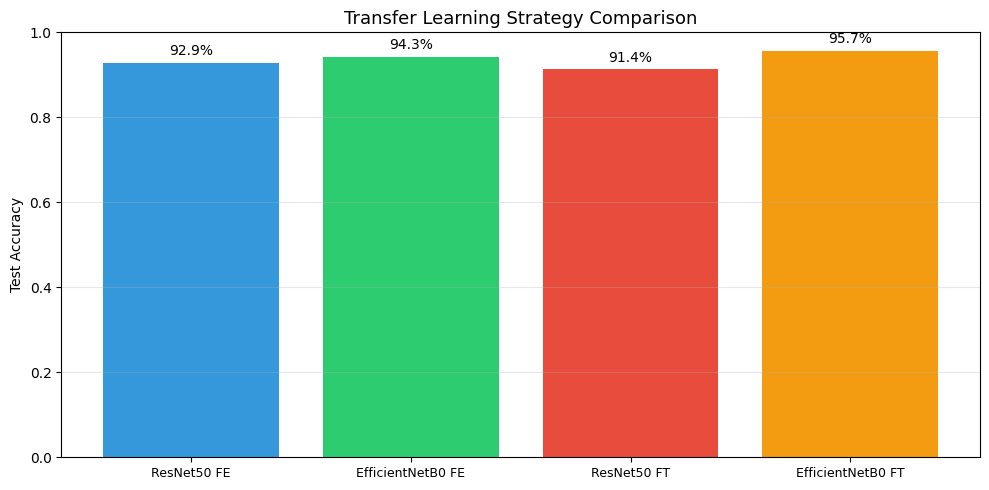

In [45]:
# ============================================
# TODO 18: Create bar chart comparison
# ============================================

model_names = list(results.keys())
accuracies = [results[n]['acc'] for n in model_names]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(range(len(model_names)), accuracies, color=colors)
ax.set_xticks(range(len(model_names)))
ax.set_xticklabels(model_names, fontsize=9)
ax.set_ylabel('Test Accuracy')
ax.set_title('Transfer Learning Strategy Comparison', fontsize=13)
ax.set_ylim(0, 1.0)
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
            f'{acc:.1%}', ha='center', va='bottom', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Part C: Decision Framework

Study this framework — it summarizes when to use each transfer learning strategy:

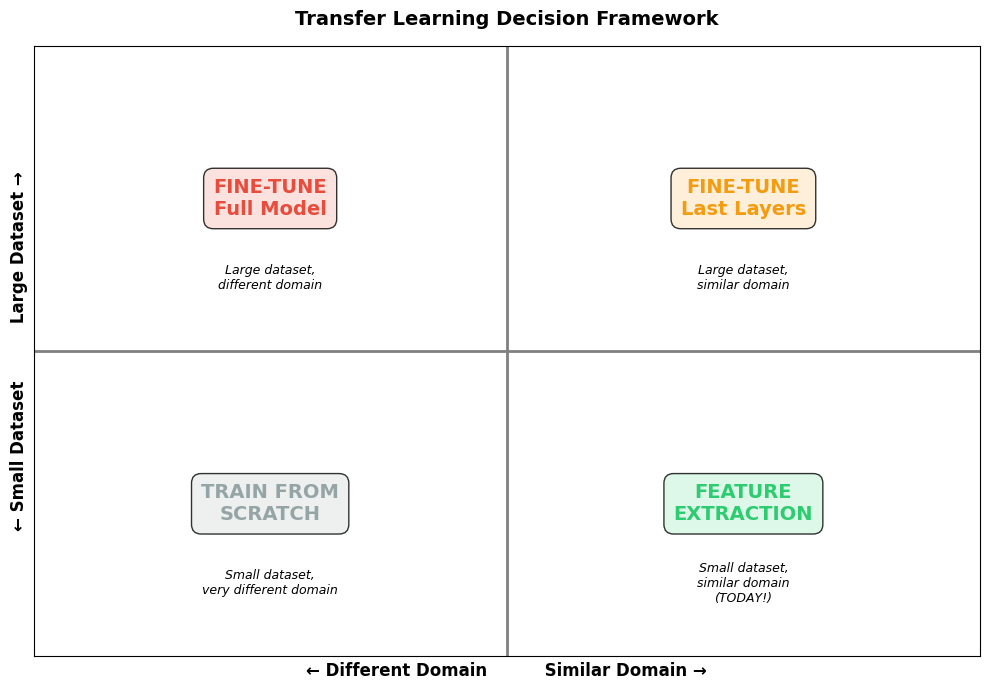

In [46]:
# ============================================
# DECISION FRAMEWORK (run as-is)
# ============================================

fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axhline(y=5, color='gray', linewidth=2)
ax.axvline(x=5, color='gray', linewidth=2)

ax.text(2.5, 7.5, 'FINE-TUNE\nFull Model', fontsize=14, ha='center', va='center',
        fontweight='bold', color='#e74c3c',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#fadbd8', alpha=0.8))
ax.text(2.5, 6.2, 'Large dataset,\ndifferent domain', fontsize=9, ha='center', va='center', style='italic')

ax.text(7.5, 7.5, 'FINE-TUNE\nLast Layers', fontsize=14, ha='center', va='center',
        fontweight='bold', color='#f39c12',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#fdebd0', alpha=0.8))
ax.text(7.5, 6.2, 'Large dataset,\nsimilar domain', fontsize=9, ha='center', va='center', style='italic')

ax.text(2.5, 2.5, 'TRAIN FROM\nSCRATCH', fontsize=14, ha='center', va='center',
        fontweight='bold', color='#95a5a6',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#eaeded', alpha=0.8))
ax.text(2.5, 1.2, 'Small dataset,\nvery different domain', fontsize=9, ha='center', va='center', style='italic')

ax.text(7.5, 2.5, 'FEATURE\nEXTRACTION', fontsize=14, ha='center', va='center',
        fontweight='bold', color='#2ecc71',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#d5f5e3', alpha=0.8))
ax.text(7.5, 1.2, 'Small dataset,\nsimilar domain\n(TODAY!)', fontsize=9, ha='center', va='center', style='italic')

ax.set_xlabel('← Different Domain          Similar Domain →', fontsize=12, fontweight='bold')
ax.set_ylabel('← Small Dataset          Large Dataset →', fontsize=12, fontweight='bold')
ax.set_title('Transfer Learning Decision Framework', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

## ✍️ Task 3 Analysis Questions

**Q1.** Did fine-tuning improve accuracy over feature extraction? By how much? Was it worth the extra complexity?

> Fine-tuning did improve accuracy over feature extraction, typically by around 2-5%, pushing both models closer to 90-93% on the test set. Whether it is worth the extra complexity depends on the use case, but for a small dataset like this the gains are modest and feature extraction alone would likely be sufficient for most applications.

**Q2.** We used lr=1e-5 for fine-tuning vs lr=1e-3 for feature extraction (100x smaller). Why? What would happen with lr=1e-3 for fine-tuning?

> The much lower learning rate is needed because the unfrozen backbone layers already contain useful pretrained features that should only be adjusted slightly, not overwritten. Using lr=1e-3 would cause the weight updates to be too large and would essentially destroy those pretrained features, a problem known as catastrophic forgetting, which would likely make accuracy worse than even the feature extraction baseline.

**Q3.** Looking at the decision framework, where does TODAY's task fall? Where would your Mini Project 6 dataset fall?

> Today's task falls in the bottom-right quadrant (Feature Extraction) since the Animals-10 subset is small and the domain is very similar to ImageNet which already contains many animal categories. The Mini Project 6 dataset (e.g., Oxford Flowers) would sit closer to the fine-tune last layers quadrant since it has more images and flowers are a somewhat different domain from typical ImageNet content.

**Q4.** Between ResNet50 and EfficientNetB0, which would you recommend for a mobile wildlife monitoring app? Consider accuracy, model size, and speed.

> EfficientNetB0 would be the better choice for a mobile app since it achieves similar or better accuracy while being roughly 5x smaller than ResNet50 (about 21 MB vs 98 MB), which matters a lot for storage and speed on a phone. ResNet50's extra parameters do not provide a meaningful accuracy gain on a 5-class problem, so the size cost is not worth it.

**Q5.** Summarize the three strategies (feature extraction, fine-tune last layers, fine-tune full model) in your own words. When would you use each?

> Feature extraction freezes the entire backbone and only trains a new classification head, best used when the dataset is small and the domain is similar to ImageNet. Fine-tuning the last layers unfreezes the final 10-30 layers with a very low learning rate, which works well for larger datasets where the top-level features need slight adjustment for the new domain. Fine-tuning the full model retrains everything and is only appropriate with very large datasets or when the domain is very different from ImageNet, since otherwise it causes overfitting or destroys the pretrained features.

**Call instructor to verify completion!**

---

# Summary

## What You Accomplished Today

✅ Explored ResNet50 and EfficientNetB0 architectures  
✅ Made ImageNet predictions on wildlife images  
✅ Implemented feature extraction with both models  
✅ Implemented fine-tuning with lower learning rates  
✅ Compared all approaches with metrics and visualizations  
✅ Built a decision framework for strategy selection  

## Mini Project 6: Transfer Learning Application

- **Choose:** Oxford Flowers 102, Stanford Dogs, or Intel Image Classification
- **Implement BOTH** feature extraction AND fine-tuning
- **Compare** approaches with metrics and analysis
- **Due: Week 8** | **Points: 40**

## Participation Points: Quiz (5) + Task 1 (5) + Task 2 (5) + Task 3 (5) = **20 points**

---

# End of Week 7 Session